In [1]:

import torch
from torch import nn, optim
import torchvision
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device('cuda')

In [4]:
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalizing image
    ])

data_dir ='archive/birds'


train_data = ImageFolder(data_dir+'/train',transform = transform)
valid_data = ImageFolder(data_dir+'/valid',transform = transform)
test_data = ImageFolder(data_dir+'/test',transform = transform)

train_loader = DataLoader(dataset=train_data,batch_size = 64,shuffle = True )
valid_loader = DataLoader(dataset=valid_data,batch_size = 64 ,shuffle = True)
test_loader = DataLoader(dataset=test_data,batch_size = 64 ,shuffle = True)


In [5]:
import os

classes = os.listdir("archive/birds/train")
classes.sort()
classes
len(classes) 

275

In [6]:
images, labels = next(iter(train_loader)) 
print(images.shape)

torch.Size([64, 3, 32, 32])


In [7]:
def imshow(img):
    # img = img.numpy()
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))

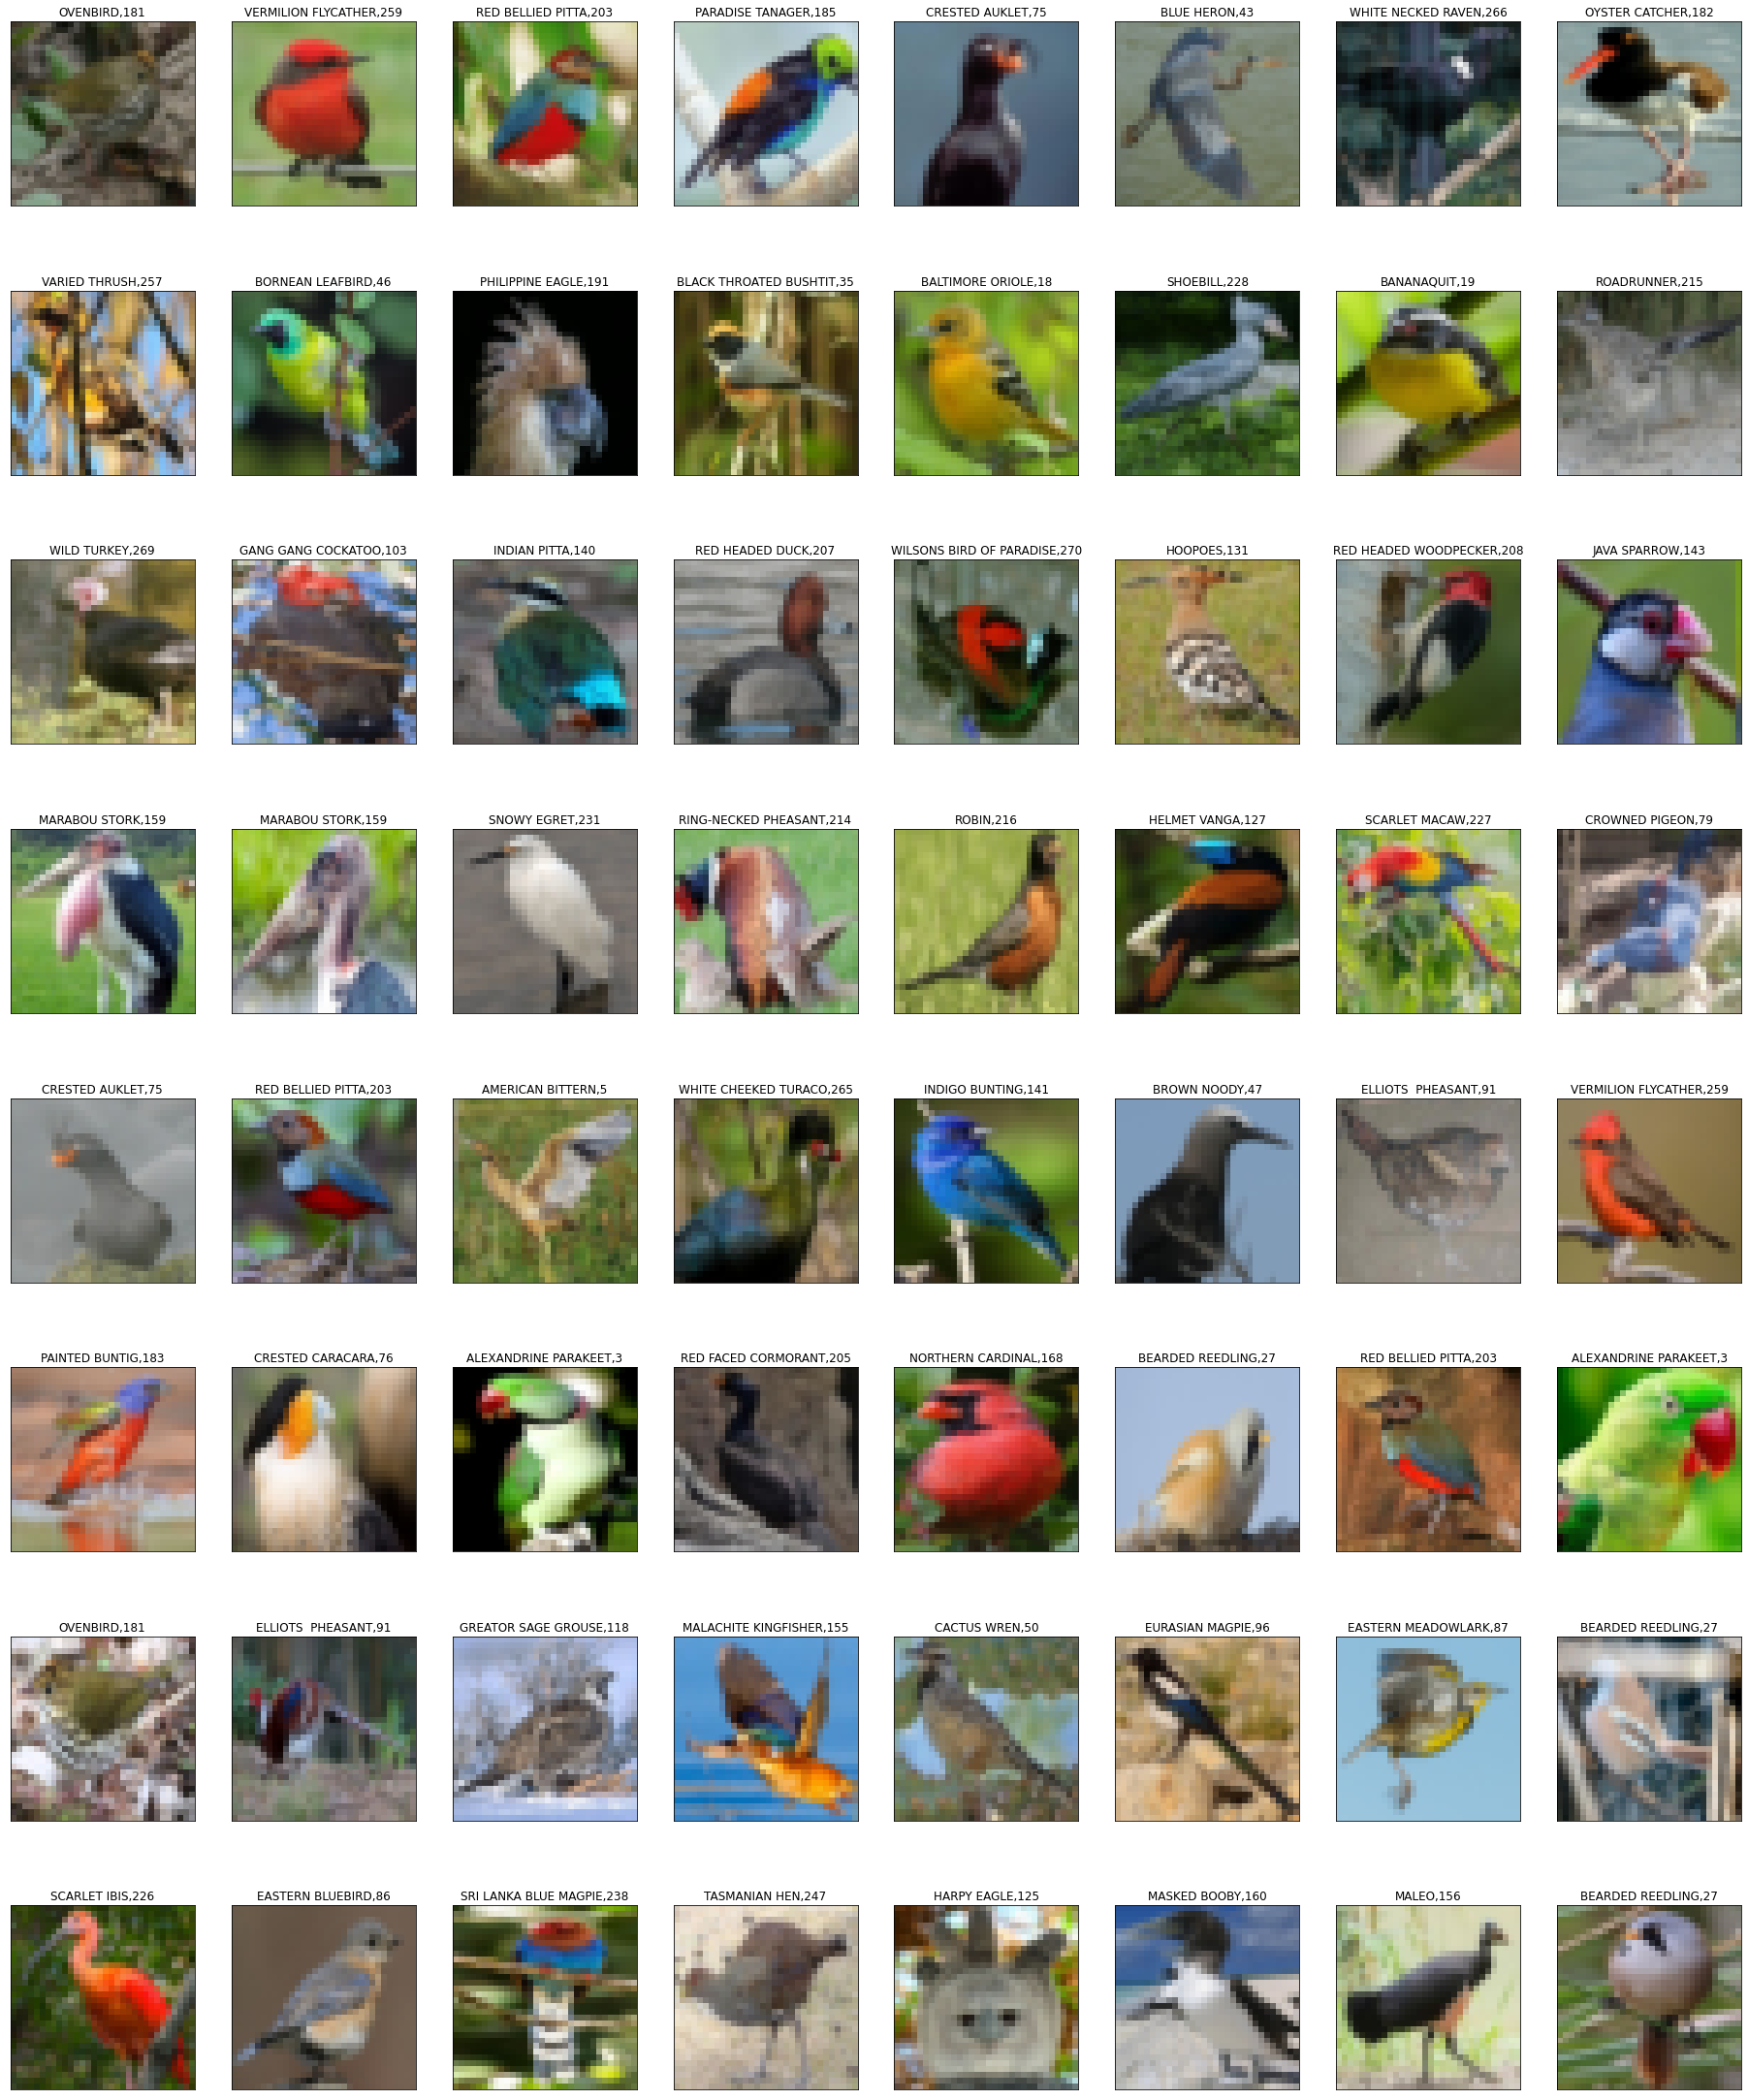

In [8]:
fig = plt.figure(figsize = (32, 40))

for i in range(64):
    subplt = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[])
    
    #Un-normalising image
    img = images[i]/2 + 0.5 
    
    #plotting image
    plt.imshow(np.transpose(img, (1, 2, 0)))
    subplt.set_title(f"{classes[labels[i]]},{labels[i]}")

In [9]:
class ConvNet(nn.Module):
    def __init__(self):
        
        super(ConvNet, self).__init__()
        self.block = nn.Sequential(
            
            nn.Conv2d(3, 6, 5), # in_channels, out_channels, kernel_size, stride, padding
            nn.MaxPool2d(2, 2), # kernel_size, stride

            nn.Conv2d(6, 16, 5), 
            nn.MaxPool2d(2, 2),
            
        )
        
        self.block2 = nn.Sequential(
            
            nn.Linear(16 * 5 * 5, 64),
            nn.ReLU(),

            nn.Linear(64, 300),
            nn.ReLU(),

            nn.Linear(300, 275),
            nn.ReLU(),
            
        )
        
    def forward(self, x):
        y = self.block(x)
        y = y.view(x.shape[0], -1) 
        y = self.block2(y)
        return y

In [10]:
model = ConvNet().to(device)

def opt(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        torch.nn.init.zeros_(m.bias.data)
        
model.apply(opt)
print(model)

ConvNet(
  (block): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Linear(in_features=400, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=275, bias=True)
    (5): ReLU()
  )
)


In [11]:
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr = 0.05, momentum = 0.09, dampening = 0.001)
epochs = 60

In [12]:
train_losses = []
val_losses = []

for i in range(epochs):
    total_loss, correct, val_total_loss, val_correct = 0,0,0,0
    for x, y in train_loader:
        
        x = x.to(device)
        y = y.to(device)
        
        pred = model(x)
        loss = loss_fn(pred , y)
        total_loss += loss.item() #Adding loss of each batch
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
        _, predicted = torch.max(pred, 1) #Getting the index with max probability
        correct += (predicted == y).sum().item()
        
    model.eval()    
    for x, y in valid_loader:
        
        x = x.to(device)
        y = y.to(device)
        
        pred = model(x)
        loss = loss_fn(pred , y)
        val_total_loss += loss.item() #Adding loss of each batch
        
        _, predicted = torch.max(pred, 1) #Getting the index with max probability
        val_correct += (predicted == y).sum().item()
        
    total_loss /= len(train_loader.dataset) # average of total loss of all batches
    train_losses.append(total_loss) #Collecting loss of each epoch for plotting graph
    
    val_total_loss /= len(valid_loader.dataset) # average of total loss of all batches
    val_losses.append(val_total_loss) #Collecting loss of each epoch for plotting graph
    
    correct /= len(train_loader.dataset)
    val_correct /= len(valid_loader.dataset)
    
    print(f"[=============Epochs: {i+1} ============]")
    print(f"Train_Loss : {total_loss:.5f}")
    print(f"Train_Accuracy : {correct:.5f}")
    print('')
    print(f"Valid_Loss : {val_total_loss:.5f}")
    print(f"Valid_Accuracy : {val_correct:.5f}")

C:\Users\GAURAV\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[=============Epochs: 1 ============]
Train_Loss : 0.08737
Train_Accuracy : 0.00879

Valid_Loss : 0.08840
Valid_Accuracy : 0.01382
[=============Epochs: 2 ============]
Train_Loss : 0.08327
Train_Accuracy : 0.03165

Valid_Loss : 0.08362
Valid_Accuracy : 0.03709
[=============Epochs: 3 ============]
Train_Loss : 0.07590
Train_Accuracy : 0.08391

Valid_Loss : 0.08449
Valid_Accuracy : 0.07127
[=============Epochs: 4 ============]
Train_Loss : 0.06714
Train_Accuracy : 0.15446

Valid_Loss : 0.09370
Valid_Accuracy : 0.06255
[=============Epochs: 5 ============]
Train_Loss : 0.06003
Train_Accuracy : 0.21482

Valid_Loss : 0.11233
Valid_Accuracy : 0.07491
[=============Epochs: 6 ============]
Train_Loss : 0.05429
Train_Accuracy : 0.26588

Valid_Loss : 0.09140
Valid_Accuracy : 0.10036
[=============Epochs: 7 ============]
Train_Loss : 0.04998
Train_Accuracy : 0.30947

Valid_Loss : 0.06057
Valid_Accuracy : 0.22327
[=============Epochs: 8 ============]
Train_Loss : 0.04602
Train_Accuracy : 0.34882

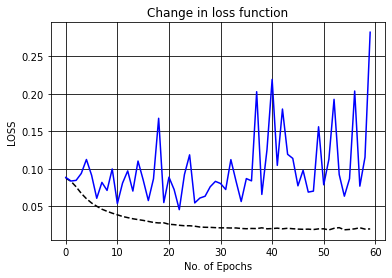

In [13]:
plt.plot(train_losses, 'k--', label = 'train_loss')
plt.plot(val_losses, 'b', label = 'valid_loss')
plt.title("Change in loss function")
plt.xlabel("No. of Epochs")
plt.ylabel("LOSS")
plt.grid(True, color = "k")
plt.show()

In [14]:
classes_correct = np.zeros(275)
classes_sample = np.zeros(275)
correct = 0
test_pred = []
with torch.no_grad():
    
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        outputs = model(x_test)
        
        _, predicted = torch.max(outputs, 1) 
        correct += (predicted == y_test).sum().item()
        
        for i in range(y_test.shape[0]):
            label = y_test[i]
            pred = predicted[i]
            test_pred.append(pred.item())
            if (pred == label):
                classes_correct[label] += 1
            classes_sample[label] += 1
        
    correct/=len(test_loader.dataset)
    print(f"Total Accuracy: {correct:.5f}")
    print('')
        
    for i in range(275):
        print(f"Accuracy of {classes[i]} : {classes_correct[i]/classes_sample[i]:.5f} ")

Total Accuracy: 0.11564

Accuracy of AFRICAN CROWNED CRANE : 0.20000 
Accuracy of AFRICAN FIREFINCH : 0.00000 
Accuracy of ALBATROSS : 0.20000 
Accuracy of ALEXANDRINE PARAKEET : 0.00000 
Accuracy of AMERICAN AVOCET : 0.00000 
Accuracy of AMERICAN BITTERN : 0.20000 
Accuracy of AMERICAN COOT : 0.20000 
Accuracy of AMERICAN GOLDFINCH : 0.00000 
Accuracy of AMERICAN KESTREL : 0.00000 
Accuracy of AMERICAN PIPIT : 0.00000 
Accuracy of AMERICAN REDSTART : 0.00000 
Accuracy of ANHINGA : 0.00000 
Accuracy of ANNAS HUMMINGBIRD : 0.20000 
Accuracy of ANTBIRD : 0.00000 
Accuracy of ARARIPE MANAKIN : 0.60000 
Accuracy of ASIAN CRESTED IBIS : 0.00000 
Accuracy of BALD EAGLE : 0.20000 
Accuracy of BALI STARLING : 0.40000 
Accuracy of BALTIMORE ORIOLE : 0.00000 
Accuracy of BANANAQUIT : 0.20000 
Accuracy of BANDED BROADBILL : 0.00000 
Accuracy of BAR-TAILED GODWIT : 0.00000 
Accuracy of BARN OWL : 0.20000 
Accuracy of BARN SWALLOW : 0.00000 
Accuracy of BARRED PUFFBIRD : 0.00000 
Accuracy of BAY-BR

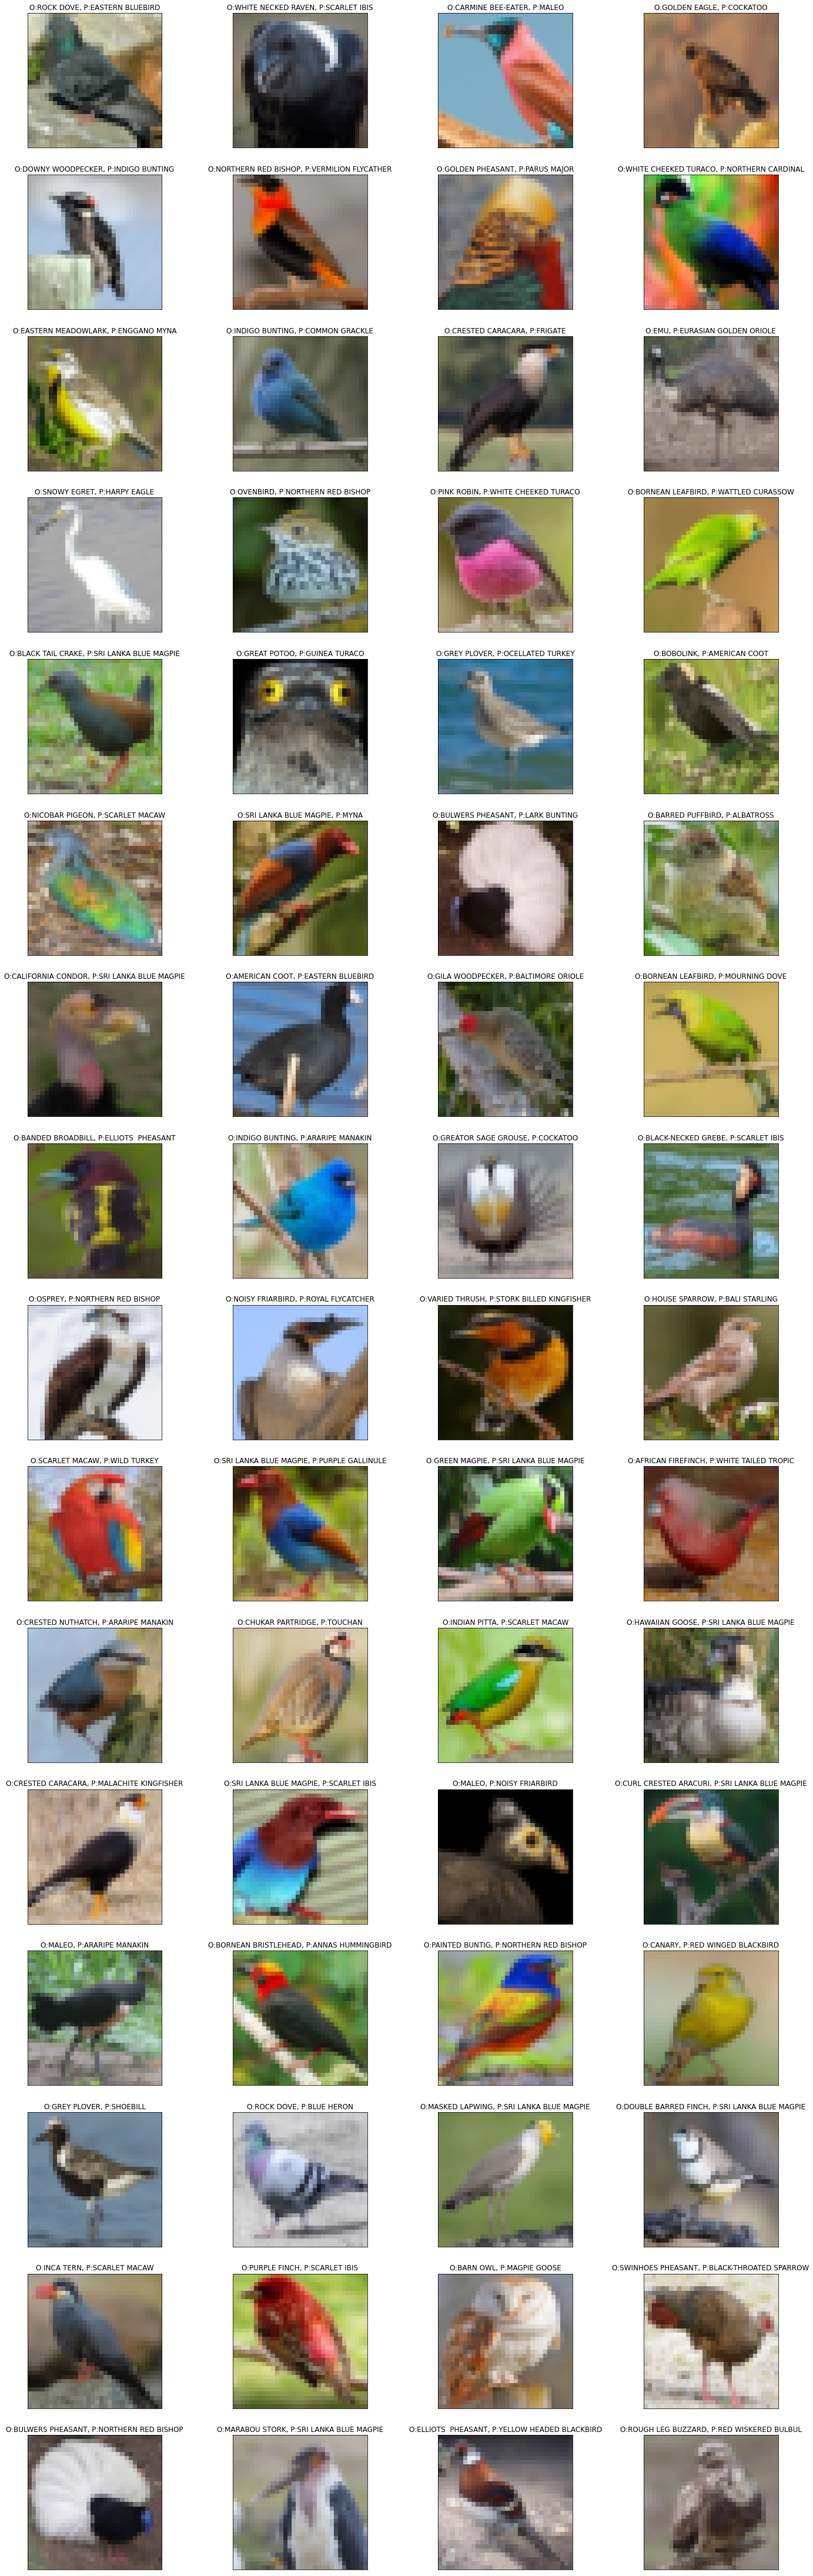

In [15]:
images, labels = next(iter(test_loader))

fig = plt.figure(figsize = (24, 80))

for i in range(64):
    subplt = fig.add_subplot(16,4, i+1, xticks=[], yticks=[])
    img = images[i]/2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))
    subplt.set_title(f"O:{classes[labels[i]]}, P:{classes[test_pred[i]]}")